In [181]:
import os
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
import matplotlib.pyplot as plt

In [182]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

In [183]:
def load(filename, seq_len, window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if window:
        result = windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    return [x_train, y_train, x_test, y_test]

In [184]:
def windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [185]:
def build_model_data(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

In [186]:
def predict_sequencesMultiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def predictPointByPoint(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [187]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

def plot_resultsMultiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [188]:
global_start_time = time.time()
epochs  = 1
seq_len = 50
print('> Loading data... ')
X_train, y_train, X_test, y_test = load('stock_price.csv', seq_len, True)
print('> X_train ......')
print(X_train)

> Loading data... 
> X_train ......
[[[ 0.        ]
  [ 0.00884493]
  [ 0.01669615]
  ..., 
  [ 0.08078511]
  [ 0.06969693]
  [ 0.07583624]]

 [[ 0.        ]
  [ 0.00326981]
  [ 0.00472427]
  ..., 
  [ 0.01516503]
  [ 0.01108344]
  [ 0.03071343]]

 [[ 0.        ]
  [-0.00327287]
  [ 0.00411666]
  ..., 
  [-0.10466478]
  [-0.09483752]
  [-0.1002157 ]]

 ..., 
 [[ 0.        ]
  [-0.00478899]
  [-0.00523174]
  ..., 
  [ 0.02043039]
  [ 0.00620781]
  [ 0.00150904]]

 [[ 0.        ]
  [ 0.01003483]
  [ 0.01765671]
  ..., 
  [-0.01216279]
  [-0.01220736]
  [-0.01175324]]

 [[ 0.        ]
  [-0.02069113]
  [-0.0127448 ]
  ..., 
  [ 0.05861936]
  [ 0.06950939]
  [ 0.070692  ]]]


In [189]:
print('> y_train ......')
print(y_train)

> y_train ......
[ 0.09140105  0.05282389 -0.07366595 ...,  0.00309034 -0.01456694
  0.07285304]


In [190]:
print('> X_test ......')
print(X_test)

> X_test ......
[[[  0.00000000e+00]
  [  5.14346191e-06]
  [  1.11707103e-02]
  ..., 
  [  5.86539766e-02]
  [  5.84022033e-02]
  [  4.10963023e-02]]

 [[  0.00000000e+00]
  [  1.11655094e-02]
  [  9.58287384e-03]
  ..., 
  [  5.83967595e-02]
  [  4.10909474e-02]
  [  4.58130122e-02]]

 [[  0.00000000e+00]
  [ -1.56515980e-03]
  [ -1.66675378e-02]
  ..., 
  [  2.95949948e-02]
  [  3.42649175e-02]
  [  1.74957729e-02]]

 ..., 
 [[  0.00000000e+00]
  [  2.05178759e-04]
  [ -3.50228952e-03]
  ..., 
  [  5.92367277e-02]
  [  5.95786330e-02]
  [  5.83086832e-02]]

 [[  0.00000000e+00]
  [ -3.70670775e-03]
  [  2.29048363e-03]
  ..., 
  [  5.93612746e-02]
  [  5.80915853e-02]
  [  5.97911018e-02]]

 [[  0.00000000e+00]
  [  6.01950391e-03]
  [  3.92149166e-03]
  ..., 
  [  6.20282135e-02]
  [  6.37340530e-02]
  [  6.54693322e-02]]]


In [191]:
print('> y_test ......')
print(y_test)

> y_test ......
[ 0.04581839  0.02885663  0.01104222  0.00403093  0.04019949  0.0468995
  0.07387159  0.0904503   0.11064464  0.10873938  0.12149329  0.12229705
  0.10260451  0.08134931  0.06022826  0.04850267  0.02654783  0.03121281
  0.05123794  0.03010504  0.02318517  0.01422806 -0.00335969 -0.01245906
  0.00363802 -0.00050401  0.00044803  0.01536963  0.00665276  0.00853567
 -0.00426834 -0.01822654 -0.00910372 -0.02269608 -0.01508435  0.00063945
 -0.00547558 -0.00047491 -0.00673619 -0.00981603 -0.00204551  0.00046914
  0.01706407  0.01472983  0.01253899  0.01339821  0.01063899  0.02426333
  0.02419621  0.04409368  0.0385835   0.05414194  0.05773435  0.07332436
  0.04714118  0.01809602  0.01467662 -0.00350247 -0.00131593 -0.01811817
 -0.02323378 -0.01177675 -0.01295464  0.01082619  0.00781269  0.03905811
  0.04327355  0.0405746   0.02050299  0.02283339  0.01616659  0.01637142
  0.02473561  0.04695707  0.02400187  0.0183629   0.01714464  0.00846774
  0.0119455   0.01206064  0.03036628

In [192]:
print('> Data Loaded. Compiling...')
model = build_model_data([1, 50, 100, 1])

> Data Loaded. Compiling...
('> Compilation Time : ', 0.026710033416748047)


In [193]:
model.fit(X_train,y_train,batch_size=512,nb_epoch=epochs,validation_split=0.05)

Train on 3523 samples, validate on 186 samples
Epoch 1/1
3523/3523 [==============================] - 13s 4ms/step - loss: 0.0026 - val_loss: 7.2593e-04


('Training duration (s) for sequences multiple: ', 24.426142930984497)


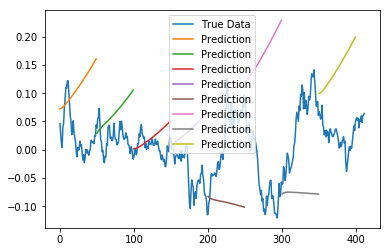

In [194]:
predictions = predict_sequencesMultiple(model, X_test, seq_len, 50)
print('Training duration (s) for sequences multiple: ', time.time() - global_start_time)
plot_resultsMultiple(predictions, y_test, 50)

('Training duration (s) for Point by point : ', 25.343677043914795)


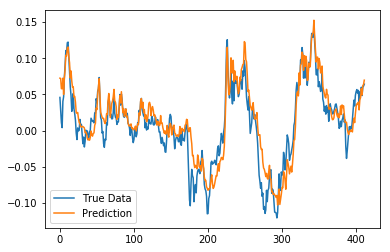

In [195]:
predictedPointByPoint = predictPointByPoint(model, X_test)
print('Training duration (s) for Point by point : ', time.time() - global_start_time)
plot_results(predictedPointByPoint, y_test)